In [9]:
import os
os.environ['DGLBACKEND'] = 'mxnet'
import dgl
import networkx as nx
import mxnet as mx
from mxnet import gluon
import math
import dgl.function as fn

In [2]:
def disjoint_chains(n_chains, length):
    path_graph = nx.path_graph(n_chains * length).to_directed()
    for i in range(n_chains - 1):  # break the path graph into N chains
        path_graph.remove_edge((i + 1) * length - 1, (i + 1) * length)
        path_graph.remove_edge((i + 1) * length, (i + 1) * length - 1)
    for n in path_graph.nodes:
        path_graph.add_edge(n, n)  # add self connections
    return path_graph

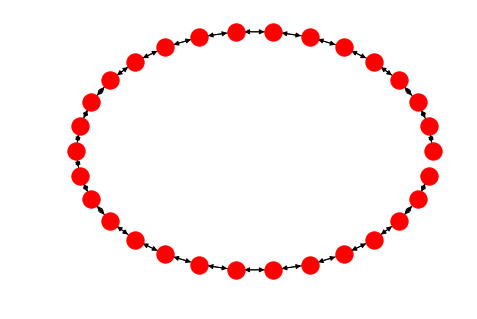

In [5]:
g1 = disjoint_chains(1, 30)
nx.draw(g1, pos=nx.circular_layout(g1))

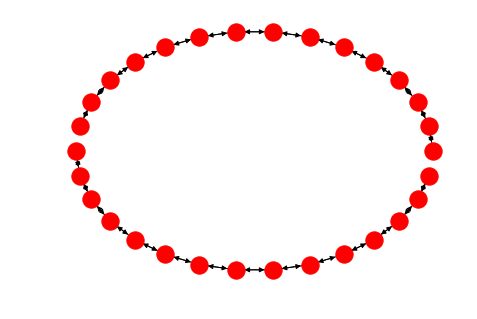

In [4]:
g2 = disjoint_chains(2, 15)
nx.draw(g2, pos=nx.circular_layout(g2))

In [37]:
n_train_samples = 100
n_epochs = 100
lr = 3e-2
weight_decay = 5e-4

train_mask = mx.nd.zeros((g.number_of_nodes()))
train_mask[0:n_train_samples] = 1
eval_mask = mx.nd.zeros((g.number_of_nodes()))
eval_mask[n_train_samples:] = 1

## Here we define a GCN model

In [28]:
class GCNLayer(gluon.Block):
    def __init__(self,
                 g,
                 in_feats,
                 out_feats,
                 activation,
                 dropout,
                 bias=True):
        super(GCNLayer, self).__init__()
        self.g = g
        with self.name_scope():
            stdv = 1. / math.sqrt(out_feats)
            self.weight = self.params.get('weight', shape=(in_feats, out_feats),
                    init=mx.init.Uniform(stdv))
            if bias:
                self.bias = self.params.get('bias', shape=(out_feats,),
                    init=mx.init.Uniform(stdv))
            else:
                self.bias = None
        self.activation = activation
        self.dropout = dropout

    def forward(self, h):
        if self.dropout:
            h = mx.nd.Dropout(h, p=self.dropout)
        h = mx.nd.dot(h, self.weight.data(h.context))
        # normalization by square root of src degree
        h = h * self.g.ndata['norm']
        self.g.ndata['h'] = h
        self.g.update_all(fn.copy_src(src='h', out='m'),
                          fn.sum(msg='m', out='h'))
        h = self.g.ndata.pop('h')
        # normalization by square root of dst degree
        h = h * self.g.ndata['norm']
        # bias
        if self.bias is not None:
            h = h + self.bias.data(h.context)
        if self.activation:
            h = self.activation(h)
        return h

class GCN(gluon.Block):
    def __init__(self,
                 g,
                 in_feats,
                 n_hidden,
                 n_classes,
                 n_layers,
                 activation,
                 dropout):
        super(GCN, self).__init__()
        self.layers = gluon.nn.Sequential()
        # input layer
        self.layers.add(GCNLayer(g, in_feats, n_hidden, activation, 0.))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.add(GCNLayer(g, n_hidden, n_hidden, activation, dropout))
        # output layer
        self.layers.add(GCNLayer(g, n_hidden, n_classes, None, dropout))

    def forward(self, features):
        h = features
        for layer in self.layers:
            h = layer(h)
        return h
    
def evaluate(model, features, labels, mask):
    pred = model(features).argmax(axis=1)
    accuracy = ((pred == labels) * mask).sum() / mask.sum().asscalar()
    return accuracy.asscalar()

In [33]:
g = dgl.DGLGraph(disjoint_chains(1, 10000), readonly=True)
labels = mx.nd.zeros([g.number_of_nodes()])
labels[mx.nd.arange(0, g.number_of_nodes(), 2)] = 1

In [35]:
degs = g.in_degrees().astype('float32')
norm = mx.nd.power(degs, -0.5)
g.ndata['norm'] = mx.nd.expand_dims(norm, 1)
features = mx.nd.eye(g.number_of_nodes(), g.number_of_nodes())

model = GCN(g, in_feats=features.shape[1], n_hidden=16, n_classes=2, n_layers=2, activation=mx.nd.relu, dropout=0.5)
model.initialize()
trainer = gluon.Trainer(model.collect_params(), 'adam',
            {'learning_rate': lr, 'wd': weight_decay})

h = model(features)
loss_fcn = gluon.loss.SoftmaxCELoss()
for epoch in range(n_epochs):
    with mx.autograd.record():
        pred = model(features)
        loss = loss_fcn(pred, labels, mx.nd.expand_dims(train_mask, 1))
        loss = loss.sum() / n_train_samples
    loss.backward()
    trainer.step(batch_size=1)
    
    acc = evaluate(model, features, labels, eval_mask)
    print(acc)

0.49747476
0.5
0.5
0.5
0.499899
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.50050503
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.499899
0.5
0.5
0.5
0.5
0.5
0.499899
0.50030303
0.499899
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5016162
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.499899
0.499899
0.499899
0.50171715
0.5
0.5
0.5
0.5
0.5
0.5
0.499899
0.5
0.499899
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.499899
0.499899
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.499899
0.499899
0.5
0.5
0.5


## here we define an SSE model

In [40]:
class SteadyStateOperator(gluon.Block):
    def __init__(self, n_hidden, activation, **kwargs):
        super(SteadyStateOperator, self).__init__(**kwargs)
        with self.name_scope():
            self.dense1 = gluon.nn.Dense(n_hidden, activation=activation)
            self.dense2 = gluon.nn.Dense(n_hidden)

    def forward(self, g):
        def message_func(edges):
            x = edges.src['x']
            h = edges.src['h']
            return {'m' : mx.nd.concat(x, h, dim=1)}

        def reduce_func(nodes):
            m = mx.nd.sum(nodes.mailbox['m'], axis=1)
            z = mx.nd.concat(nodes.data['x'], m, dim=1)
            return {'h' : self.dense2(self.dense1(z))}

        g.update_all(message_func, reduce_func)
        return g.ndata['h']

def update_embeddings(g, steady_state_operator):
    prev_h = g.ndata['h']
    next_h = steady_state_operator(g)
    g.ndata['h'] = (1 - alpha) * prev_h + alpha * next_h
    
class Predictor(gluon.Block):
    def __init__(self, n_hidden, activation, **kwargs):
        super(Predictor, self).__init__(**kwargs)
        with self.name_scope():
            self.dense1 = gluon.nn.Dense(n_hidden, activation=activation)
            self.dense2 = gluon.nn.Dense(2)  ## binary classifier

    def forward(self, g):
        g.ndata['z'] = self.dense2(self.dense1(g.ndata['h']))
        return g.ndata['z']

In [42]:
n = g.number_of_nodes()
n_hidden = 16
n_embedding_updates = 8
n_parameter_updates = 5
alpha = 0.1
batch_size = 64

g.ndata['x'] = mx.nd.eye(n, n)
g.ndata['h'] = mx.nd.zeros([n, n_hidden])

steady_state_operator = SteadyStateOperator(n_hidden, 'relu')
steady_state_operator.initialize()
predictor = Predictor(n_hidden, 'relu')
predictor.initialize()
trainer = gluon.Trainer(model.collect_params(), 'adam',
            {'learning_rate': lr, 'wd': weight_decay})

def update_parameters(g, trainer):
    with mx.autograd.record():
        steady_state_operator(g)
        z = predictor(g)
        loss = loss_fcn(z, labels, mx.nd.expand_dims(train_mask, 1))
        loss = loss.sum() / n_train_samples
    loss.backward()
    trainer.step(1)  # divide gradients by the number of labelled nodes
    return loss.asnumpy()[0]

def train(g, trainer):
     # first phase
    for i in range(n_embedding_updates):
        update_embeddings(g, steady_state_operator)
    # second phase
    for i in range(n_parameter_updates):
        loss = update_parameters(g, trainer)
    return loss

for epoch in range(n_epochs):
    train(g, trainer)
    acc = evaluate(model, features, labels, eval_mask)
    print(acc)

KeyboardInterrupt: 